In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
import baltic as bt
import numpy as np
import pickle
from copy import deepcopy

In [2]:
out_path = './png/'
colors = pickle.load(open('./colors.p', 'r'))

genotype_tree = bt.loadNexus('../frequencies/source/annotated_tree.nexus', absoluteTime=False)
genotype_lookup = { k.traits['clade'] : k.traits['genotype'] for k in genotype_tree.Objects if 'genotype' in k.traits }
serotype_lookup = { k.traits['clade'] : k.traits['serotype'] for k in genotype_tree.Objects if 'serotype' in k.traits }

In [3]:
def antigenically_uniform(node, tree):
    descendants = [k for k in tree.traverse_tree(node, include_all=True)]
    trait_values = [round(k.traits['cTiter'], 2) for k in descendants]
    if len(set(trait_values)) > 1:
        return False
    else:
        return True
              
def reattach(k, tree):
    parent = k.parent
    k.parent.children.remove(k)
    
    if k.branchType=='node':
        children = k.children
        for child in children:
            child.parent = parent
            parent.children.append(child)
        
tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'
titer_tree = bt.loadJSON(tree_file, {'name': 'clade', 'height': 'cTiter'})


Tree height: 1.955144
Tree length: 6.071398
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [5]:
uncollapsed_tree = deepcopy(titer_tree)

In [4]:
width_lookup = { k.traits['clade'] : len([w for w in titer_tree.traverse_tree(k) 
                                          if round(w.traits['cTiter'], 2)==round(k.traits['cTiter'], 2)])
               for k in titer_tree.Objects if k.branchType=='node'}

## Get the easy antigenically-uniform clades first
uniform_nodes = [k for k in sorted(titer_tree.Objects, key=lambda k: k.height) if antigenically_uniform(k, titer_tree)]
uniform_mrcas = [k for k in uniform_nodes if k.parent not in uniform_nodes and k.branchType=='node']

for k in sorted(uniform_mrcas, key = lambda k: k.height):
    titer_tree.collapseSubtree(k, k.traits['clade'], lambda x: 1)
        
## Go back to clean up remaining polytomies
to_remove = []

for k in sorted(titer_tree.Objects, key=lambda k:-1*k.height):
    if k.traits['dTiter'] < 0.01:
        reattach(k, titer_tree)
        to_remove.append(k)

for k in to_remove:
    titer_tree.Objects.remove(k)
    
for k in titer_tree.Objects:
    if k.traits['clade'] in width_lookup:
        k.traits['width'] = width_lookup[k.traits['clade']]
    else:
        k.traits['width'] = 1
    
titer_tree.drawTree()
titer_tree.drawUnrooted()

In [7]:
# backup = deepcopy(titer_tree)
# titer_tree = deepcopy(backup)
titer_tree_string = titer_tree.toString(traits = titer_tree.Objects[5].traits.keys(), numName=True, nexus=False)
open('./collapsed_antigenic_tree.nexus', 'w').write(titer_tree_string)
titer_tree = bt.tree()
bt.make_tree(titer_tree_string, titer_tree) ## This is hacky, but fixes the collapsed-node-vs-tip thing
treestring = titer_tree.toString(traits = titer_tree.Objects[5].traits.keys(), numName=True, nexus=True)
titer_tree.drawTree()
titer_tree.drawUnrooted()

In [14]:
serotype_mrcas = {1: 'DENV4', 2152: 'DENV3', 2070: 'DENV1', 617: 'DENV2'}

def plot_tree(ll, ax,  cmap=colors['cmap']):
    sns.set(style='white')

    max_width = max([k.traits['width'] for k in ll.Objects if 'width' in k.traits])
    branchWidth = 3

    for k in ll.Objects: # Plot objects
        x=k.x 
        y=k.y 

        xp=k.parent.x 
        yp=k.parent.y
        if x==None:
            x=0.0
        if xp==None:
            xp=x

        ## Color
        try:
            clade = k.traits['clade']
        except:
            clade = None
        if clade in genotype_lookup and 'SYLVATIC' not in genotype_lookup[clade]:
            genotype = genotype_lookup[clade]
            label=genotype.replace('_', ' ')
            c = colors[genotype]
        elif clade in serotype_lookup:
            serotype = serotype_lookup[clade]
            c = colors[serotype]
            if clade in serotype_mrcas:
                label = serotype
            else:
                label = ''
        else:
            print k.branchType, [w.traits for w in k.children], k.traits
            c = 'darkgray'
            label='interserotype'

        if 'clade' in k.traits:
            label = str(k.traits['clade'])
        s = 400
        if 'width' in k.traits:
            s = s*k.traits['width']/max_width

#         if label != 'interserotype':
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        ax.text(x+0.1, y, label, ha='left', va='center')

        ax.plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',size=0) ## no labels
    ax.tick_params(axis='y',size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

node [{u'tau': 0.0, u'num_date': 1835.010679, u'xvalue': 0.21795, u'width': 2.0, u'clade': 1.0, u'region_entropy': 3.9e-05, u'tvalue': 367.90548, u'dTiter': 0.221414, u'cTiter': 0.221414, u'div': 0.217945, u'serum': 0.0, u'yvalue': 2549.62645, u'num_date_confidence': [1830.09415064, 1839.6883883]}, {u'tau': 1.0471975511965976, u'num_date': 1467.961648, u'xvalue': 0.0, u'width': 0.0, u'clade': 616.0, u'region_entropy': 0.002865, u'tvalue': 0.85645, u'dTiter': 0.221414, u'cTiter': 0.221414, u'div': 0.0, u'serum': 0.0, u'yvalue': 1671.07475, u'num_date_confidence': [1459.14557073, 1476.13488184]}] {'tau': 0.0}
node [{u'tau': 1.0471975511965976, u'num_date': 1771.114272, u'xvalue': 0.15314, u'width': 65.0, u'clade': 617.0, u'region_entropy': 0.104647, u'tvalue': 304.00908, u'dTiter': 0.746876, u'cTiter': 0.96829, u'div': 0.153144, u'serum': 0.0, u'yvalue': 2185.48323, u'num_date_confidence': [1764.97414574, 1777.43816652]}, {u'tau': 2.0943951023931953, u'num_date': 1782.368431, u'xvalue': 

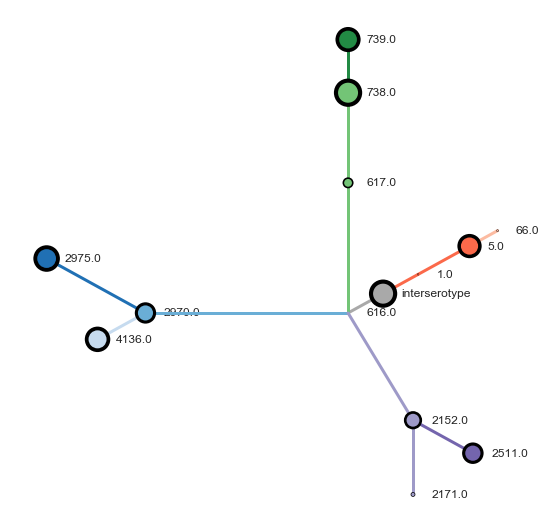

In [15]:
sns.set(style='white', font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5)) # quarter page

plot_tree(titer_tree, ax=ax)#, cmap=cmap)

plt.tight_layout()
# plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# import matplotlib as mpl
# import matplotlib.gridspec as gridspec

# def plot_radial_tree(tree, ax, cax, cmap=colors['cmap']):
    
#     ## Color bar and formatting
#     sns.set(style='white', font_scale=1.2)
# #     max_c = max([k.traits[colorby] for k in tree.Objects if colorby in k.traits ])
    
# #     norm = mpl.colors.Normalize(vmin=0, vmax=max_c)
# #     cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, orientation='vertical', 
# #                                    norm=norm, label="Cumulative log2(titer) distance from root")    
# #     cax.yaxis.set_label_position('left')
# #     cax.yaxis.set_ticks_position('left')
# #     cb.set_label("Cumulative log2(titer) distance from root", )

#     ## Setup params
#     branchWidth=3 
#     inwardSpace=-1.15 # < -1 points outwards; > 1 points inwards
#     gap=0.6 # determines how much of their allocated space along the circle a tree uses
#     startFrom=np.pi ## start at some point along the circle

#     ## Bounds
#     leaves = [k for k in tree.Objects if k.branchType=='leaf']
#     leafCount = len(leaves)
#     mostRecent = max([float(k.traits['cTiter']) for k in leaves])
#     max_width = max([k.traits['width'] for k in tree.Objects if isinstance(k, bt.clade)])

#     ## Plot Objects
#     for k in tree.Objects: 
#         ### Coordinates
#         y=k.y 
#         x=k.x 
#         xp=k.parent.x 

#         if x==None: 
#             x=0.0
#         if xp==None:
#             xp=x

#         ### Convert to polar
#         xc=inwardSpace+((mostRecent-x)/tree.treeHeight) ## transform x coordinate
#         xpc=inwardSpace+((mostRecent-xp)/tree.treeHeight) ## transform x parent's coordinate
#         yc=2*np.pi*(y/float(leafCount))*gap ## transform y coordinate

#         ### Color
#         clade = k.traits['clade']
#         if clade in genotype_lookup and 'SYLVATIC' not in genotype_lookup[clade]:
#             genotype = genotype_lookup[clade]
#             c = colors[genotype]
#         elif clade in serotype_lookup:
#             serotype = serotype_lookup[clade]
#             c = colors[serotype]
#         else:
#             c = 'darkgray'

#         if k.branchType=='leaf': ### Plot tips and clades
#             if isinstance(k, bt.clade):
#                 s = k.traits['width']
#             else:
#                 s = 20
#             ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=50) ## plot circle for every tip
#             ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=40) ## plot black circle underneath

#         elif isinstance(k,bt.node): ### Plot nodes
#             yl=k.children[-1].y 
#             yr=k.children[0].y 
#             ycl=2*np.pi*(yl/float(leafCount))*gap 
#             ycr=2*np.pi*(yr/float(leafCount))*gap 
#             ybar=np.linspace(ycl,ycr,15) ## create a curved bar
#             ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color=c,ls='-',zorder=30) ## plot curved bar at the base of a node

#         ### Plot ancestralbranch
#         ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color=c,ls='-',zorder=30)

                     
#     ## Final axis formatting
#     ax.spines['top'].set_visible(False) 
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

#     ax.tick_params(axis='x',size=0) 
#     ax.tick_params(axis='y',size=0)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     ax.set_aspect(1) 
#     x0,x1 = plt.xlim()
#     plt.xlim((x0-0.1, x1+0.1))
#     y0,y1 = plt.ylim()
#     plt.ylim((y0-0.2,y1+0.3))

# titer_tree.drawTree()
# sns.set(style='white', font_scale=1.2)
# fig, (cax, ax) = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 7.5), gridspec_kw={'width_ratios': (0.02, 1.)}) # quarter page

# plot_tree(titer_tree, ax=ax, cax=cax)

# circles = [patches.Circle((0,0), radius=n, axes=ax, ec='lightgray', fc='none', ls='--', lw=1) for n in [0.25, 0.75, 1.25]]
# circles += [patches.Circle((0,0), radius=n, axes=ax, ec='darkgray', fc='none', ls='--', lw=1) for n in [0.5, 1.]]

# for circ in circles:
#     ax.add_patch(circ)

# plt.tight_layout()
# # plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
# plt.show()

In [25]:
# uncollapsed_tree = bt.loadJSON(tree_file, {'name': 'clade', 'height': 'xvalue'})

# # mystery_clade = [k for k in uncollapsed_tree.Objects if 'clade' in k.traits and k.traits['clade'] == 616][0]
# # descendants = [k for k in uncollapsed_tree.traverse_tree(mystery_clade)]
# # for k in descendants:
# #     print k.traits['strain']

# for k in uncollapsed_tree.Objects:
#     if 'clade' not in k.traits:
#         k.traits['clade'] = 'missing'

# uncollapsed_tree_str = uncollapsed_tree.toString(traits=['clade', 'strain', 'dTiter', 'cTiter'], numName=True, nexus=True)
# open('./uncollapsed_tree.nexus', 'w').write(uncollapsed_tree_str)


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)

